# Tutorial notebook for hera_pspec

This notebook is intended as a tutorial for all basic features of the hera_pspec package.
It includes examples of
<ul>
<li>How to copmute a delay power spectrum for different options including the choice of the input data weights, the spectral range considered (following data flagging)</li>
<li> How to convert this power spectrum in cosmological units</li>
<li> How to obtain error bars on the power spectrum, from thermal noise and from the output covariance</li>
<li> How to extract the window function and output covariance </li>
<li> How to make a wedge plot </li>
<li> How to perform coherent and incoherent time- and redundant-averages, as well as how to construct redundant baseline groups </li>
</ul>
    
The structure is as follows:
1. Delay spectrum calculation and averaging
2. Weighting, flags, and error bars
3. Window functions and covariance

This notebook was the result of a code review performed by Hugh Garsden and Adélie Gorce between January and June 2021. It might be updated once new features have been added to the module.

---

## Data description 

Import Python packages, set cosmology, beam, pol, data sets.

In [1]:
from pyuvdata import UVData, UVFlag
import hera_pspec as hp
import hera_qm as hq
import numpy as np
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
colorlist = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c','#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5','#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f','#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
%matplotlib inline

/users/hgarsden/.local/lib/python3.8/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/users/hgarsden/.local/lib/python3.8/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/users/hgarsden/.local/lib/python3.8/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/users/hgarsden/.local/lib/python3.8/site-packages/hera_sim/__init__.py:23: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's A

In [2]:
#### cosmology
cosmo = hp.conversions.Cosmo_Conversions()

Import data

In [3]:
##################
###### DATA ######
##################

# select the data file to load
dfile = os.path.join(DATA_PATH, 'sim4.uvh5')
# Load into UVData objects
uvd = UVData()
uvd.read(dfile)
# Check which baselines are available
# print('Available baselines: ', uvd.get_antpairs())

Telescope hera_sim is not in known_telescopes.


Extract beam information

In [4]:
##################
###### BEAM ######
##################

# List of beamfile to load. This is a healpix map.
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
# intantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

In [5]:
#########################
##### POLARISATION ######
#########################

pol = 'xx'

In [6]:
###### CHOOSE DATA TO USE

# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)
print('%i frequency channels ranging from %.1f to %.1f MHz with channel width %i kHz' %(uvd1.freq_array.shape[1],uvd1.freq_array[0,0]/1e6,uvd1.freq_array[0,-1]/1e6,uvd1.channel_width/1e3))

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)

# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

60 frequency channels ranging from 100.0 to 119.7 MHz with channel width 333 kHz


# Delay spectrum calculation and averaging

## Delay spectrum

**1.1** Calculate the (incoherently) time- and redundant baseline-averaged delay spectrum (a) for a single redundant baseline group, (b) in the presence of flags that are separable in time and frequency, (c) excluding auto-baselines, and (d) with identity weighting

(a) Choose redundant baseline group

In [7]:
###############################
#### REDUNDANT BASELINES ######
###############################

# sort baselines in redundant groups
baseline_group, _, _ = uvd.get_redundancies()

#convert baseline number to antenna numbers tuple
blp_group = []
for group in baseline_group:
    g = []
    for i,bl in enumerate(group):
        g.append(uvd.baseline_to_antnums(bl))
    blp_group.append(g)

# choose one redundancy group for which to compute the power spectrum
baselines = blp_group[1] #first group is auto baselines
print('Baselines considered: %s' %baselines)

Baselines considered: [(0, 1), (1, 2), (3, 4), (4, 5), (5, 6), (7, 8), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (18, 19), (19, 20), (20, 21), (21, 22), (23, 24), (24, 25), (25, 26), (27, 28), (28, 29)]


(b) Find unflagged spectral ranges 

The simulated data does not include flags, so we artificially add some RFI.

In [8]:
uvd.flag_array[:,:,:9]=True
uvd.flag_array[:,:,50:53]=True

In [9]:
# uvf = UVFlag(uvd,mode='flag',copy_flags=True)
# uvf.flag_array[:,:,10:]=True
# uvf.flag_array[:,:,50:53]=False
# uvutils.apply_uvflag(uvd, uvf, inplace=True, unflag_first=False, flag_missing=True, force_pol=True)

We choose the spectral range among data flagged as True.

In [10]:
spw_range = (10,49)
freq_range = [uvd.freq_array[0,i]/1e6 for i in spw_range]
print('Frequencies considered range from %.1f to %.1f MHz' %(freq_range[0],freq_range[1]))

Frequencies considered range from 103.3 to 116.3 MHz


This is illustrated in the figure below, where blue regions are False flags, yellow True flags and the hatched region corresponds to the spectral range considered.

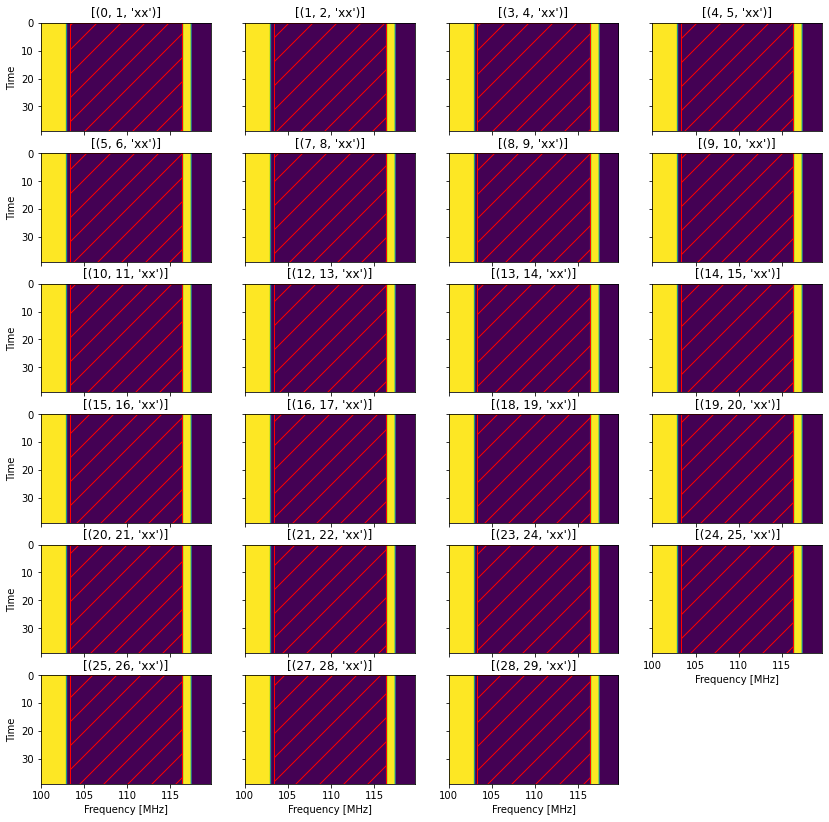

In [11]:
###################
###### FLAGS ######
###################

fig, axes = plt.subplots(6,4,figsize=(14,14))
u=0
for i,bl in enumerate(baselines):
    if (u>3):
        u=0
    il = i//4
    ic = u
    ax = axes[il,ic]
    
    key = [(bl[0],bl[1],pol)]
    ax.imshow(uvd.get_flags(key),aspect='auto',extent=(uvd.freq_array[0,0]/1e6,uvd.freq_array[0,-1]/1e6,uvd.Ntimes-1,0))
    ax.axvspan(freq_range[0],freq_range[1],fill=False,color='red',hatch='/')

    if (il==5) or ((il==4 and u==3)):
        ax.set_xlabel('Frequency [MHz]')
    else:
        ax.set_xticklabels([])
    if (ic==0):
        ax.set_ylabel('Time')
    else: 
        ax.set_yticklabels([])
    ax.set_title(key)
    
    u=u+1
axes[-1,-1].set_visible(False)


The spectral range we choose to consider is shown as a red region on the above figure.

(c) Construct baseline pairs, excluding auto-baselines

In [12]:
# construct all baseline pairs from group
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines,exclude_permutations=True,
                                                            exclude_auto_bls=True)

(d) Compute power spectrum for identity weighting of data

In [13]:
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False,
              input_data_weight='identity')

Casting complex values to real discards the imaginary part


No handles with labels found to put in legend.


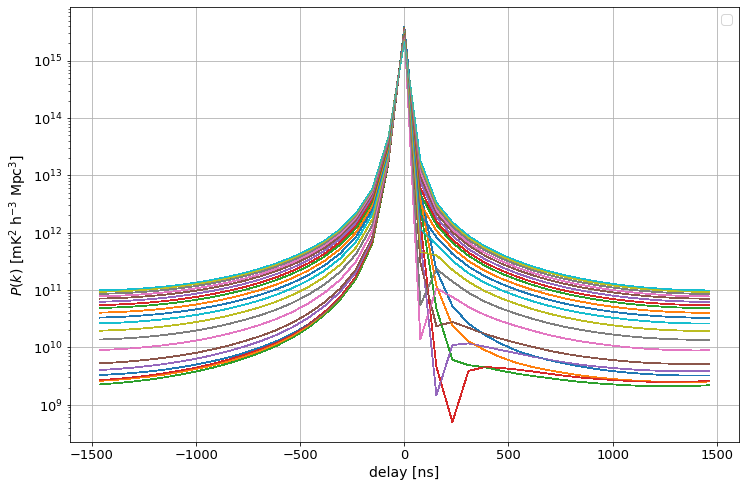

In [14]:
# plot results
spw = 0
dlys = uvp.get_dlys(spw)*1e9 #ns
fig, ax = plt.subplots(figsize=(12,8))
for u,blp in enumerate(blpairs):
    key = (spw, blp, pol)
    power = np.abs(np.real(uvp.get_data(key)))
    _ = ax.plot(dlys, power.T,lw=.8)
blp = blpairs[0]
ax.set_yscale('log')
ax.grid()
ax.legend(fontsize=14)
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.tick_params(labelsize=13)

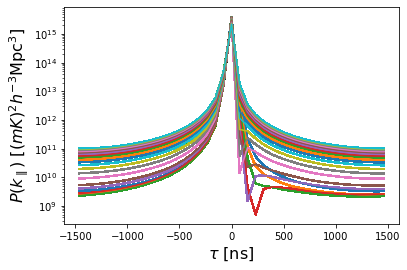

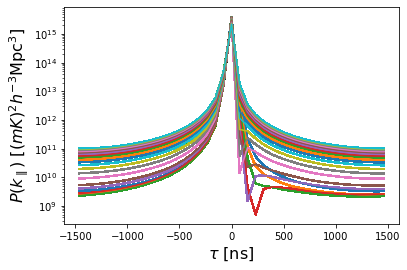

In [15]:
hp.plot.delay_spectrum(uvp, blpairs, spw, pol,force_plot=True)

If more that one time of measurement, plot the different delay spectra for each time and the time-averaged spectrum.

In [16]:
# time-average the power spectrum for this group
uvp2 = uvp.average_spectra(time_avg=True, inplace=False)

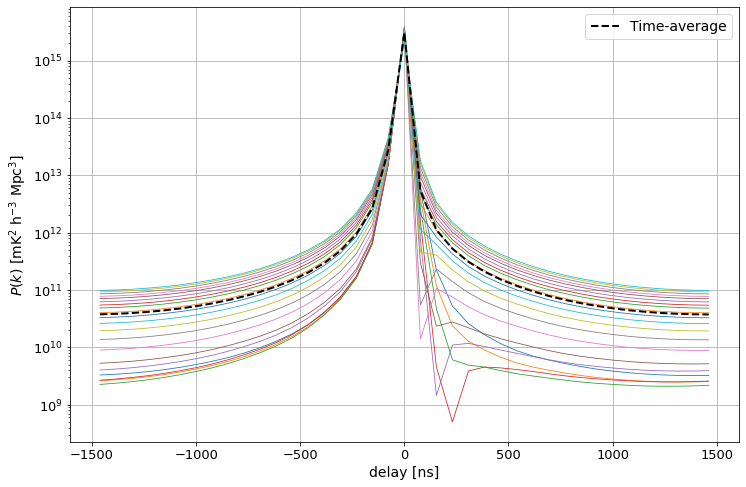

In [17]:
# plot results for one baseline
blp = blpairs[4]
spw = 0
key = (spw, blp, pol)
power = np.abs(np.real(uvp.get_data(key)))
ps_avg_ints = np.abs(np.real(uvp2.get_data((spw, blp, pol)))).flatten()

fig, ax = plt.subplots(figsize=(12,8))
_ = ax.plot(dlys, power.T,lw=.8)
ax.plot(dlys,ps_avg_ints,color='k',lw=2,label='Time-average',ls='--')
ax.set_yscale('log')
ax.grid()
ax.legend(fontsize=14)
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.tick_params(labelsize=13)

## Cosmological power spectrum

**1.2** As in 1.1, but spherically averaged in k, with correct cosmological units and normalisation.

In [18]:
dsq = copy.deepcopy(uvp2) # make a copy of the UVPSpec object
dsq.convert_to_deltasq() # convert to dimless power spectrum

In [19]:
# k_parallel and k_perp
k_perp, k_para = dsq.get_kperps(spw, little_h=True), dsq.get_kparas(spw, little_h=True)
blpt_inds = dsq.blpair_to_indices(dsq.get_blpairs()[0])#redundant baseline group: unique k_perp
k_arr = np.sqrt(k_perp[blpt_inds][0]**2 + k_para**2)

In [20]:
# binning in k
dk = 0.05
kbins = np.arange(0.005, 0.7, dk)

In [21]:
# spherical average the time-averaged spectrum
uvp3 = hp.grouping.spherical_average(dsq,kbins,bin_widths=dk)

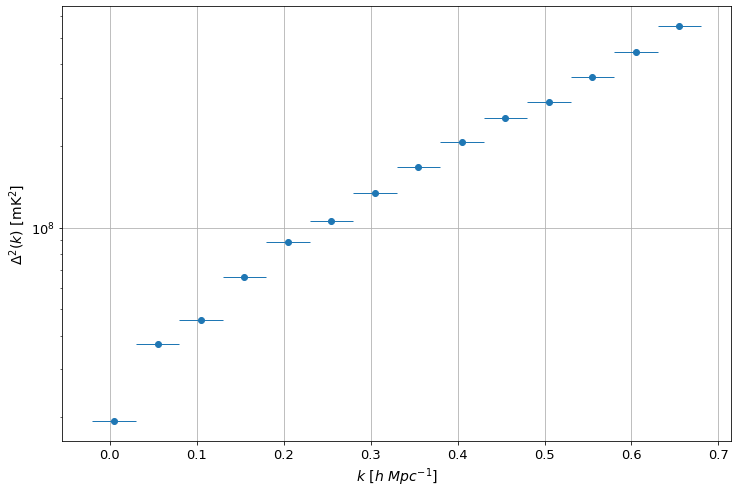

In [22]:
blp = blpairs[0]
ps = np.abs(np.real(uvp3.get_data((spw, blp, pol)))).flatten()

fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(kbins,ps,xerr=dk/2,marker='o',lw=0.,elinewidth=1.)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k\ [h\ Mpc^{-1}]$", fontsize=14)
ax.set_ylabel(r"$\Delta^2(k)\ \rm [mK^2]$", fontsize=14)
ax.tick_params(labelsize=13)

## Wedge plot

**1.3** Calculate the (incoherently) time- and redundant baseline-averaged delay spectrum (a) in the presence of flags that are separable in time and frequency, (b) excluding auto-baselines, (c) with identity weighting, and (d) presented as a wedge plot (2D/cylindrical average).

1. Redundant average

In [23]:
# get redundant groups
groups, _, _ = uvd.get_redundancies(include_autos=False)

In [24]:
# construct baseline pairs within redundant groups
# convert to antenna number tuples
baselines1, baselines2 = [], []
bl_groups, bl_pairs = [], []
for group in groups:
    antpairs = [uvd.baseline_to_antnums(j) for j in group]
    bl_groups.append(antpairs)
    bls1, bls2, blpairs = hp.utils.construct_blpairs(antpairs,exclude_permutations=True,exclude_auto_bls=True)
    if len(blpairs)>0:
        bl_pairs.append(blpairs)
    baselines1 += bls1
    baselines2 += bls2

Note that we could use the hp.utils.calc_blpair_reds function but we choose the above method as it allows us to output the grouped baseline pairs, later used when averaging the spectrum. The function also does not consider zero-baselines (ex: (24,24)).

In [25]:
b1, b2, bp, _, _ = hp.utils.calc_blpair_reds(uvd,uvd, exclude_auto_bls=True)

In [26]:
# construct PS from all available baselines, cross-correlating them even if not redundant
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False)

Casting complex values to real discards the imaginary part


2. Wedge plot

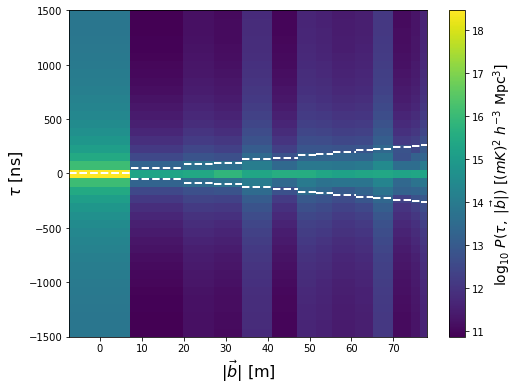

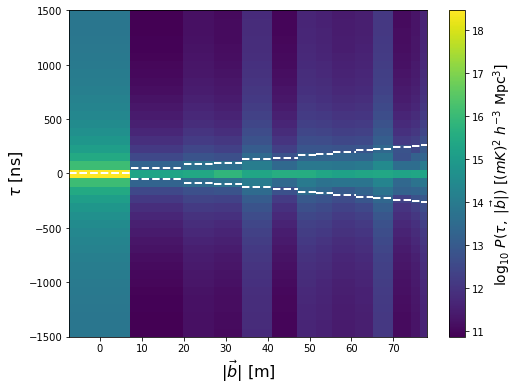

In [27]:
hp.plot.delay_wedge(uvp,spw,(pol,pol),ax=None,delay=True, rotate=True, horizon_lines=True, colorbar=True)

## Wedge plot for coherently and incoherently averaged spectra

**1.4** Make a wedge plot of the difference between the coherently- and incoherently-averaged 2D delay spectrum.
Note: Coherent average = average before squaring data

#### Redundant groups

In [28]:
# construct baseline pairs within redundant groups
groups, _, _ = uvd.get_redundancies(include_autos=False)

In [29]:
# construct baseline pairs within redundant groups
# convert to antenna number tuples
baselines1, baselines2, ungrouped_pairs = [], [], []
bls_grouped, grouped_pairs = [], []
for group in groups:
    antpairs = [uvd.baseline_to_antnums(j) for j in group]
    bls_grouped.append(antpairs) #translate bl_grouped to ant numbers (tuples)
    #construct bl pairs within redundancy group (group)
    bls1, bls2, blpairs = hp.utils.construct_blpairs(antpairs,exclude_permutations=True,exclude_auto_bls=False)
    if len(blpairs)>0:
        grouped_pairs.append(blpairs) #group bl pairs
    baselines1 += bls1 #list first element of bl pairs
    baselines2 += bls2 #list second element of bl pairs
    ungrouped_pairs += blpairs #list bl pairs without grouping

In [30]:
grouped_pairs_notuple = [[uvp.antnums_to_blpair(blp) for blp in blpg] for blpg in grouped_pairs]
# print(grouped_pairs_notuple)

A simpler way is to derive the grouped ant pairs directly with a utils function, and then feed it to average_spectra directly.

In [31]:
blp_grps, lens, angs, tags = hp.utils.get_blvec_reds(uvp,match_bl_lens=True)

In [32]:
# compute the power spectrum: only redundant baselines are cross-correlated (corresponding to the pairs in ungrouped_pairs)
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False, input_data_weight='identity')
print(uvp.data_array[0].shape)

Casting complex values to real discards the imaginary part


(72320, 39, 1)


#### Incoherent averaging

Incoherent average is performed *after* computing the individual power spectra.

In [33]:
print('There are %i times and %i baseline pairs in uvp' %(uvp.Ntimes,uvp.Nblpairs))
# print(len(ungrouped_pairs))
print('There are %i redudant baselines groups and %i within which we can form antenna pairs' 
      %(len(groups),len(grouped_pairs)))

There are 20 times and 3616 baseline pairs in uvp
There are 51 redudant baselines groups and 51 within which we can form antenna pairs


1. Time-average

In [34]:
#no time average, no baseline average
uvp.data_array[0].shape

(72320, 39, 1)

In [35]:
# time-average the power spectrum with no baseline average
uvp2 = uvp.average_spectra(time_avg=True, inplace=False)
print(uvp2.data_array[0].shape)

(3616, 39, 1)


2. Redundant-average

In [36]:
#time-average, redundant average
uvp3 = uvp.average_spectra(blpair_groups = grouped_pairs, time_avg=True, inplace=False)
print(uvp3.data_array[0].shape)

(51, 39, 1)


NB: in the new power spectrum object, the are only 4 bl pairs, corresponding to the first pair of each group.

3. Delay spectrum

We will plot the delay spectrum for a specific redundant baseline group within the 51 available.

In [37]:
ii = 12
print('%i baseline bairs in the redundant group chosen (# %i)' %(len(grouped_pairs[ii]),ii))

78 baseline bairs in the redundant group chosen (# 12)


Text(0.5, 0.98, '100112101113')

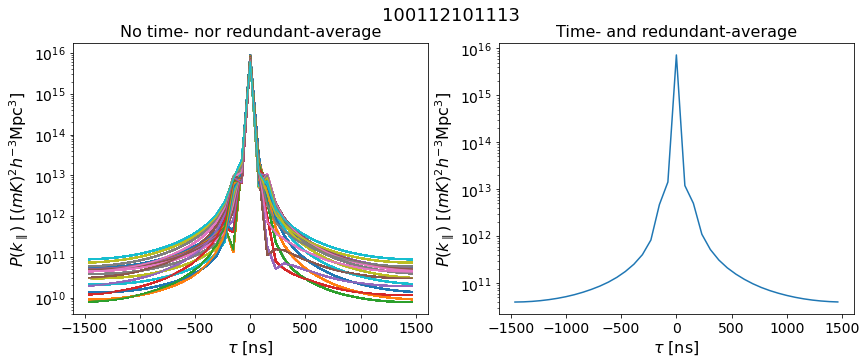

In [38]:
fig,axes= plt.subplots(1,2,figsize=(14,5))
# non-averaged power spectrum
hp.plot.delay_spectrum(uvp, [grouped_pairs[ii]], spw, pol,ax=axes[0])
axes[0].set_title('No time- nor redundant-average',fontsize=16)
axes[0].tick_params(labelsize=14)
# Averaged spectrum
hp.plot.delay_spectrum(uvp3, [uvp3.blpair_array[ii]], spw, pol,ax=axes[1])
axes[1].set_title('Time- and redundant-average',fontsize=16)
axes[1].tick_params(labelsize=14)
fig.suptitle(uvp3.blpair_array[ii],fontsize=18)

4. Wedge plot

Text(0.5, 1.0, 'Time- and redundant-average')

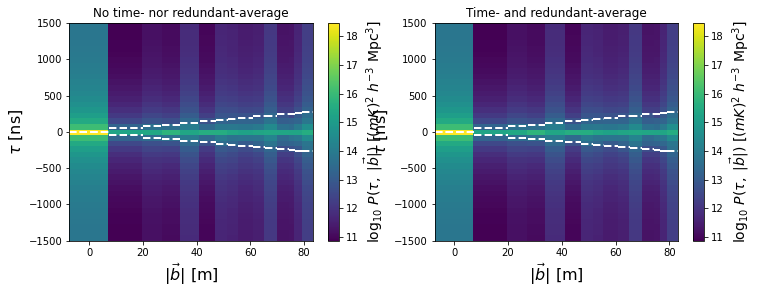

In [39]:
fig,axes= plt.subplots(1,2,figsize=(12,4))
# non-averaged power spectrum
hp.plot.delay_wedge(uvp,spw,(pol,pol),delay=True,ax=axes[0], rotate=True, horizon_lines=True, colorbar=True)
axes[0].set_title('No time- nor redundant-average')
# Averaged spectrum
hp.plot.delay_wedge(uvp3,spw,(pol,pol),delay=True,ax=axes[1], rotate=True, horizon_lines=True, colorbar=True)
axes[1].set_title('Time- and redundant-average')

### Coherent average

Coherent average is performed *before* computing the power spectrum.

1. Baseline-average

In [40]:
# coherent average along redundant groups
groups, _, _ = uvd.get_redundancies(include_autos=False)
uvd_av = uvd.compress_by_redundancy(method='average',inplace=False)
print('Number of baselines before average: %i' %uvd.Nbls)
print('Number of baselines after average: %i'%uvd_av.Nbls)

Number of baselines before average: 465
Number of baselines after average: 51


In [41]:
uvd12 = uvd_av.select(times=np.unique(uvd_av.time_array)[:-1:2], inplace=False)
uvd22 = uvd_av.select(times=np.unique(uvd_av.time_array)[1::2], inplace=False)

2. Time-average

In [42]:
uvd12.downsample_in_time(n_times_to_avg=uvd1.Ntimes)
uvd22.downsample_in_time(n_times_to_avg=uvd1.Ntimes)

Data are in drift mode, phasing before resampling.


The time difference between integrations is not the same as the integration time for baseline (0, 0). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 1). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 2). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 3). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 4). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 5). The output may average across longer time intervals than e

Unphasing back to drift mode.
Data are in drift mode, phasing before resampling.


The time difference between integrations is not the same as the integration time for baseline (0, 0). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 1). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 2). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 3). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 4). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (0, 5). The output may average across longer time intervals than e

Unphasing back to drift mode.


In [43]:
print('Number of times before average: %i' %uvd1.Ntimes)
print('Number of times after average: %i'%uvd12.Ntimes)

Number of times before average: 20
Number of times after average: 1


3. Power spectrum

In [44]:
ds_av = hp.PSpecData(dsets=[uvd12, uvd22], wgts=[None, None], beam=uvb)
ds_av.rephase_to_dset(0)
ds_av.dsets[0].vis_units = 'mK'
ds_av.dsets[1].vis_units = 'mK'

In [45]:
bls1, bls2, blpairs = hp.utils.construct_blpairs(uvd12.get_antpairs(),
                                                 exclude_cross_bls=True,exclude_auto_bls=False)

In [46]:
uvp_av = ds_av.pspec(bls1, bls2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], 
                                                 verbose=False, input_data_weight='identity')

Casting complex values to real discards the imaginary part


#### Comparison coherent / incoherent averaging

In [47]:
print(uvp3.Ntimes,uvp3.Nblpairs)
print(uvp_av.Ntimes,uvp_av.Nblpairs)

1 51
1 51


1. Delay spectrum

Text(0.5, 1.0, 'Coherent average')

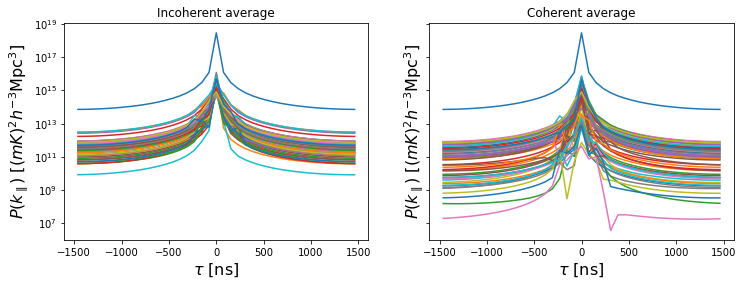

In [48]:
fig,axes= plt.subplots(1,2,figsize=(12,4),sharey=True)
# incoherent average
hp.plot.delay_spectrum(uvp3, uvp3.blpair_array, spw, pol,ax=axes[0])
axes[0].set_title('Incoherent average')
# Coherent average
hp.plot.delay_spectrum(uvp_av, uvp_av.blpair_array, spw, pol,ax=axes[1])
axes[1].set_title('Coherent average')

In [49]:
delays = uvp3.get_dlys(spw) * 1e9 #ns

blp1 = (uvd.baseline_to_antnums(uvd.get_redundancies()[0][0][0]),uvd.baseline_to_antnums(uvd.get_redundancies()[0][0][1]))
# blp1 = uvp3.get_blpairs()[0]
incoherent_ps = np.abs(np.real(uvp3.get_data((spw, blp1, pol)))).flatten()

# blp2 = uvp_av.get_blpairs()[0]
blp2 = (uvd.baseline_to_antnums(uvd.get_redundancies()[0][0][0]),uvd.baseline_to_antnums(uvd.get_redundancies()[0][0][0]))
coherent_ps = np.abs(np.real(uvp_av.get_data((spw, blp2, pol)))).flatten()

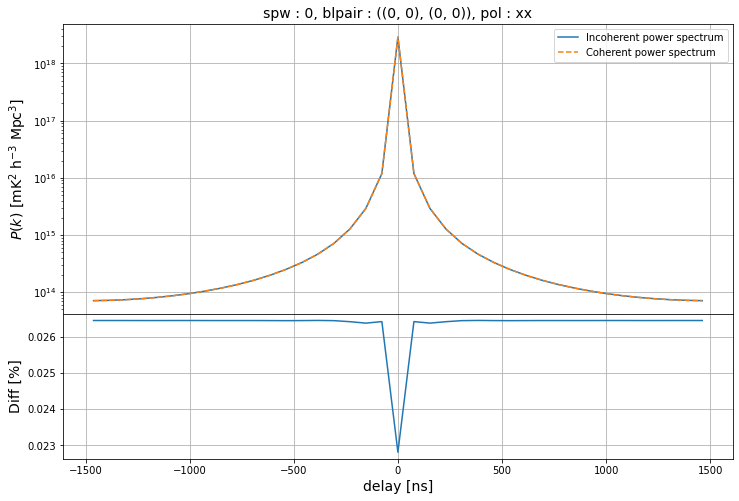

In [50]:
fig, axes = plt.subplots(2,1,figsize=(12,8),gridspec_kw={'hspace':0,'height_ratios':(2,1)})

axes[0].plot(delays, incoherent_ps,label='Incoherent power spectrum')
axes[0].plot(delays, coherent_ps,ls='--',label='Coherent power spectrum')
axes[1].plot(delays, (incoherent_ps-coherent_ps)/coherent_ps*100)

axes[0].set_yscale('log')
axes[1].set_xlabel("delay [ns]", fontsize=14)
axes[0].set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
axes[1].set_ylabel(r"Diff [%]", fontsize=14)
axes[0].set_title("spw : {}, blpair : {}, pol : {}".format(spw,blp2,pol), fontsize=14)
axes[0].legend()
for i in range(len(axes)):
    axes[i].grid()

2. Wedge plot

Text(0.5, 1.0, 'Coherent average')

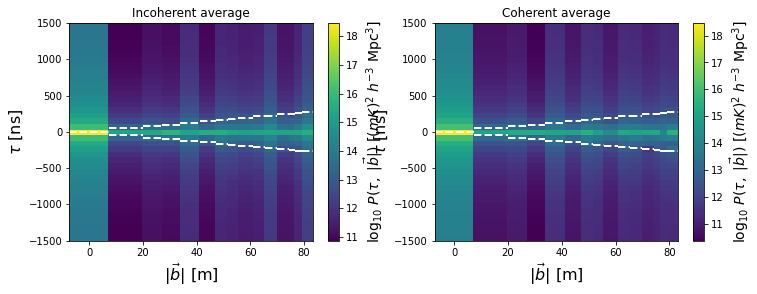

In [51]:
fig,axes= plt.subplots(1,2,figsize=(12,4))
# incoherent average
hp.plot.delay_wedge(uvp3,spw,(pol,pol),delay=True,ax=axes[0], rotate=True, horizon_lines=True, colorbar=True)
axes[0].set_title('Incoherent average')
# Coherent average
hp.plot.delay_wedge(uvp_av,spw,(pol,pol),delay=True,ax=axes[1], rotate=True, horizon_lines=True, colorbar=True)
axes[1].set_title('Coherent average')

Wedge plot of the difference

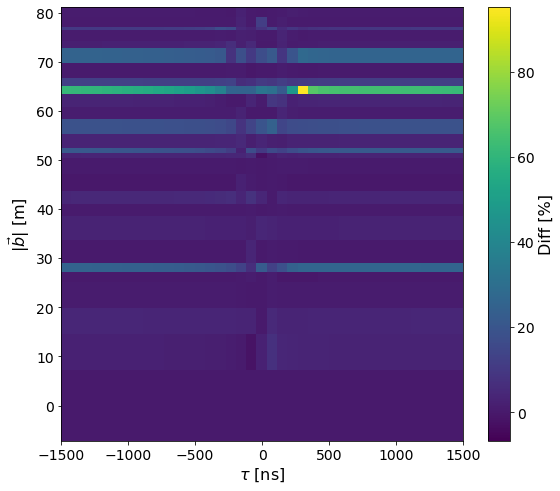

In [52]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

data = np.zeros((2,uvp3.Nblpairs,uvp3.Ndlys))
for i,uvp in enumerate([uvp3,uvp_av]):
    blpairs, blpair_seps = uvp.get_blpairs(), uvp.get_blpair_seps()
    osort = np.argsort(blpair_seps)
    blpairs, blpair_seps = [blpairs[oi] for oi in osort], blpair_seps[osort]
    y_axis = blpair_seps
    data1 = [uvp.get_data((spw, blp, pol)).squeeze() for blp in blpairs]
    data1 = np.abs(np.real(data1))
    data[i,:,:] = np.log10(data1)

x_axis = uvp.get_dlys(spw) * 1e9
xdiff = np.diff(x_axis)
x_edges = np.array([x_axis[0]-xdiff[0]/2.0] + list(x_axis[:-1]+xdiff/2.0) + [x_axis[-1]+xdiff[-1]/2.0])
ydiff = np.diff(y_axis)
y_edges = np.array([y_axis[0]-ydiff[0]/2.0] + list(y_axis[:-1]+ydiff/2.0) + [y_axis[-1]+ydiff[-1]/2.0])
X, Y = np.meshgrid(x_edges, y_edges)
psunits = '(mK)^2\ h^{-3}\  {\rm Mpc}^3'

cax = ax.pcolormesh(X, Y, (data[0,:,:]-data[1,:,:])/data[1,:,:]*100, cmap='viridis', edgecolor='none', lw=0.01)
cbar = plt.colorbar(cax)
cbar.set_label('Diff [%]', fontsize=16)
ax.set_xlabel(r"$\tau$ $[{\rm ns}]$", fontsize=16)
ax.set_ylabel(r"$|\vec{b}|$ $[{\rm m}]$", fontsize=16)
ax.tick_params(labelsize=14)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(14)


## Wedge plot for coherently and incoherently averaged spectra (alternative method)

**1.4** Make a wedge plot of the difference between the coherently- and incoherently-averaged 2D delay spectrum.
Note: Coherent average = average before squaring data
    
There are alternative ways of setting up the baselines, doing the coherent averaging, and differencing incoherent/coherent power spectra

### Incoherent averaging of data, and power spectrum generation

In [53]:
# Build as many ant pairs as possible from all redundant groups 

blsp1, blsp2, _, _, _ = hp.utils.calc_blpair_reds(uvd1, uvd2, exclude_auto_bls=True, exclude_permutations=True)

# Power spectrum
uvp0 = ds.pspec(blsp1, blsp2, (0, 1), [('xx', 'xx')], spw_ranges=(0,60), input_data_weight='identity', norm='I', 
                verbose=False)  

Casting complex values to real discards the imaginary part


Now average the power spectrum by time, and average all the baselines in each redundant group. 
This requires setting up a list of lists, where each sub-list is a list of baselines in each redundant group. calc_blpair_reds() doesn't do this (the grouping by redundancy). The list can be explicitly generated. Care must be made to make sure that the same baselines are used 
as for the call to ds.pspec().

Generate the list and average.

In [54]:
baseline_grps, _, _ = uvd.get_redundancies()

blpairs_all = []                         # This will be a list of lists
for group in baseline_grps[1:]:        # Ignore group 1 which is auto correlations 
  baselines_as_antennas = list(map(uvd.baseline_to_antnums, group))
  _, _, blps = hp.utils.construct_blpairs(baselines_as_antennas, exclude_auto_bls=True, exclude_permutations=True)

  if len(group) > 1:             # Including these will later produce an error "blpair 100101103104 not found in data"
    blpairs_all += [blps]     # calc_blpair_reds() has ignored them for bls1, bls2 above, so we must.


# Now can average. 
hp.grouping.average_spectra(uvp0, blpairs_all, time_avg=True)
print("Spectra grid size", uvp0.data_array[0].shape)

Spectra grid size (47, 60, 1)


Plot the power spectrum. Because the number of antennas is small, the power spectrum is not that detailed, but it shows that it can be created.

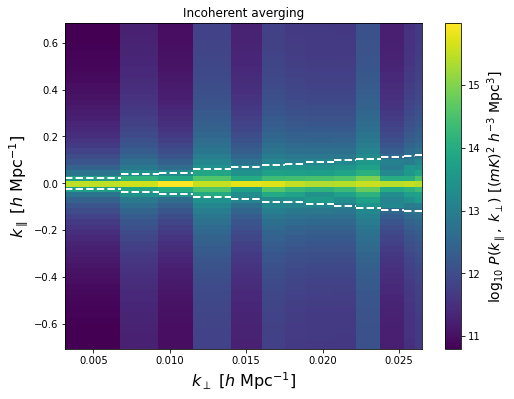

In [55]:
fig = hp.plot.delay_wedge(uvp0, 0, ("xx", "xx"), None, delay=False, rotate=True, horizon_lines=True, colorbar=True, title="Incoherent averging")

### Coherent averaging

To do the coherent averaging, use the run_red_avg() function from the H1C pipeline.

In [56]:
import pyuvdata.utils as uvutils
import hera_cal as hc

# Coherent averaging obtained from pspec pipeline

def run_red_avg(datafile, reds, wgt_by_nsample=True, inp_cals=None):

    # setup UVData
    uvd = UVData()
    uvd.read(datafile)
    pols = [uvutils.polnum2str(pol) for pol in uvd.polarization_array]

    # iterate over redundant groups and polarizations
    for pol in pols:
        for blg in reds:
            blg = [ uvd.baseline_to_antnums(bl) for bl in blg ]

            # get data and weight arrays for this pol-blgroup
            d = np.asarray([uvd.get_data(bl + (pol,)) for bl in blg])
            f = np.asarray([(~uvd.get_flags(bl + (pol,))).astype(np.float) for bl in blg])
            n = np.asarray([uvd.get_nsamples(bl + (pol,)) for bl in blg])
            if 'wgt_by_nsample':
                w = f * n
            else:
                w = f

            # take the weighted average
            wsum = np.sum(w, axis=0).clip(1e-10, np.inf)
            davg = np.sum(d * w, axis=0) / wsum
            navg = np.sum(n, axis=0)
            favg = np.isclose(wsum, 0.0)

            # replace in UVData with first bl of blg
            blinds = uvd.antpair2ind(blg[0])
            polind = pols.index(pol)
            uvd.data_array[blinds, 0, :, polind] = davg
            uvd.flag_array[blinds, 0, :, polind] = favg
            uvd.nsample_array[blinds, 0, :, polind] = navg

    # select out averaged bls
    bls = hp.utils.flatten([[uvd.baseline_to_antnums(blg[0]) + (pol,) for pol in pols] for blg in reds])
    uvd.select(bls=bls)

    return uvd

Run the coherent averaging and setup the new UVData object. 

In [57]:
"""
Do the coherent averaging, taking into account redundant groups.
This could be done using uvd_co.compress_by_redundancy(method="average"),
but it does not do exactly the same thing. Using run_red_avg produces
a power spectrum with lower values outside the wedge.
"""

uvd_co = run_red_avg("sim2.uvh5", baseline_grps)

uvd_co.data_array *= Jy_to_mK[None, None, :, None]


Telescope hera_sim is not in known_telescopes.


\
Setup two data sets from the coherent averaging, which are the same data set, but one is shifted in time. Load these into a PSpecData object.

In [58]:
# Create two data sets from this data, shifted in time
uvd1_co = uvd_co.select(times=np.unique(uvd_co.time_array)[:-1:2], inplace=False)
uvd2_co = uvd_co.select(times=np.unique(uvd_co.time_array)[1::2], inplace=False)

# Form power spectrum
ds_int = hp.PSpecData(dsets=[uvd1_co, uvd2_co], beam=uvb)     # Include the beam
ds_int.rephase_to_dset(0)

\
Now we are ready to generate a power spectrum. However, that requires specifying baselines from each data set that can be cross-multipled (actually cross-powered).
There is only 1 baseline in each group, so simply accumulate a list of all the baselines for both data sets. The baseline in one data set will be cross-powered with the same baseline in the other data set. However we must make sure we use the same redundant groups as were used for the incoherent averaged power spectrum.

In [59]:
baseline_groups_co, _, _ = uvd_co.get_redundancies()

bls_all_co = [ uvd.baseline_to_antnums(group[0]) for group in baseline_grps[1:] if len(group) > 1 ]

# Power spectrum
uvp1 = ds_int.pspec(bls_all_co, bls_all_co, (0, 1), [('xx', 'xx')], spw_ranges=(0,60), input_data_weight='identity', 
                norm='I', verbose=False)  

Casting complex values to real discards the imaginary part


\
Now average the power spectrum by time. There is no averaging by baseline because that has already been done, therefore we use None
for the baseline pairs in average_spectra().

In [60]:
# Average. The value of None stops baselines being averaged together.
hp.grouping.average_spectra(uvp1, None, time_avg=True)
print("Spectra grid size", uvp1.data_array[0].shape)

Spectra grid size (47, 60, 1)



Plot the delay spectrum.

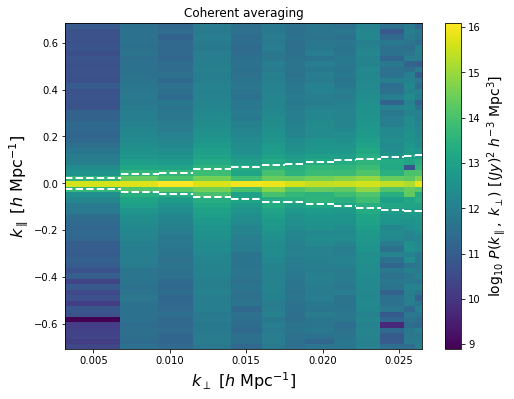

In [61]:
fig = hp.plot.delay_wedge(uvp1, 0, ("xx", "xx"), None, delay=False, rotate=True, horizon_lines=True, 
                          colorbar=True, title="Coherent averaging")

Observe and compare the power spectrum produced by incoherent averaging with the one produced by coherent averaging.
- They are different in their details, but overall much the same.
- The coherent-averaged power spectrum has a lower minimum.


Now we are ready to get the difference between the incoherently and coherently averaged power spectra. First we check that the shapes of the power spectra are the same. Getting the same shape is the reason for all the baseline shenanigans above. 

In [62]:
assert uvp1.data_array[0].shape == uvp0.data_array[0].shape, "Power spectra are not same shape - cannot be subtracted"
uvp_diff = copy.deepcopy(uvp0)
uvp_diff.data_array[0] = uvp1.data_array[0] - uvp0.data_array[0]

Plot the difference

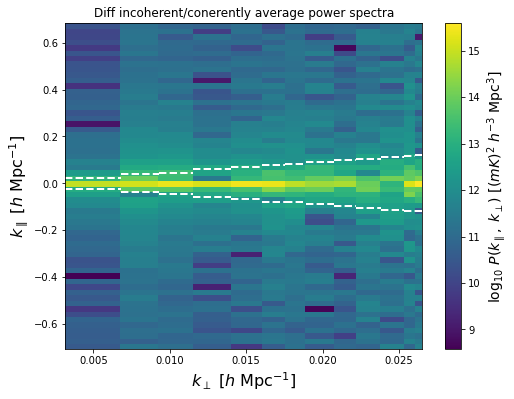

In [63]:
fig = hp.plot.delay_wedge(uvp_diff, 0, ("xx", "xx"), None, delay=False, rotate=True, horizon_lines=True, colorbar=True,
                         title="Diff incoherent/conerently average power spectra")

# Weighting, flags and errorbars

## Include thermal noise error bars

**2.1** Repeat the analysis from 1.1, but with thermal noise error bars added.

In [64]:
uvd1_Jy = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2_Jy = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

In [65]:
# List of beamfile to load. This is a healpix map.
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
# intantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

In [66]:
# calculate all baseline pairs from redundant group
baselines = blp_group[1] 
print(baselines)
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines, 
                                     exclude_auto_bls=True,exclude_permutations=False)
# power spectrum
uvp = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False, 
               exact_norm=True,store_cov=True)
# time-average
uvp2 = uvp.average_spectra(time_avg=True, inplace=False)

[(0, 1), (1, 2), (3, 4), (4, 5), (5, 6), (7, 8), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (18, 19), (19, 20), (20, 21), (21, 22), (23, 24), (24, 25), (25, 26), (27, 28), (28, 29)]


Producing time-uniform covariance matrices between bandpowers.
Casting complex values to real discards the imaginary part


In [67]:
blp = blpairs[0]
spw = 0

#### Noise power spectrum
Tsys = 220.0  # K
uvn1 = hp.testing.noise_sim(uvd1_Jy, Tsys, uvb, seed=0, inplace=False, whiten=True)
uvn2 = hp.testing.noise_sim(uvd1_Jy, Tsys, uvb, seed=1, inplace=False, whiten=True)
dsn = hp.PSpecData([copy.deepcopy(uvn1), copy.deepcopy(uvn2)], wgts=[None, None], beam=uvb)
dsn.dsets[0].vis_units = 'mK'
dsn.dsets[1].vis_units = 'mK'
uvpn = dsn.pspec(baselines1,baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False, 
                 exact_norm=True)
# get standard deviation of real component of delay spectra
P_std = np.std(uvpn.data_array[0].real.squeeze(), axis=0)
# generate theoretical noise spectrum given Tsys
P_N = uvpn.generate_noise_spectra(spw, pol, Tsys,little_h=True)[uvpn.antnums_to_blpair(blp)]

Casting complex values to real discards the imaginary part


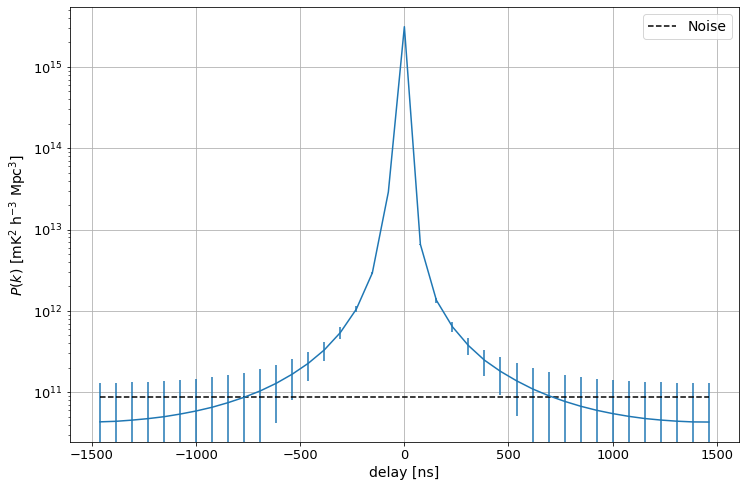

In [68]:
ps = np.abs(np.real(uvp2.get_data((spw, blp, pol))))[0,:]
dlys = uvp.get_dlys(spw)*1e9 #ns

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(dlys,P_N[0,:],lw=1.5,ls='--',color='k',label='Noise')
ax.errorbar(dlys,ps,yerr=P_N[0,:])
ax.set_yscale('log')
ax.grid()
ax.legend(fontsize=14)
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.tick_params(labelsize=13)

## Include errors propagated from the input data

**2.2** Repeat the analysis from 1.1, but with errors propagated from the input data. 

Errors can be estimated from the diagonal of the output covariance matrix. Depending on the covariance model chosen, they will include different things:
- In 'empirical' mode, error bars are estimated from the data by averaging the channel-channel covariance of each baseline over time and then applying the appropriate linear transformations to these frequency-domain covariances.
- In 'autos', only the noise-noise correlation terms are included
- In 'foreground_dependent', both noise-noise and signal-noise cross-correlations are included

In [69]:
key = (spw, blp, pol)

#analytical noise
Tsys = 300.0  #K
P_N = uvp.generate_noise_spectra(spw, pol, Tsys,little_h=True)[uvpn.antnums_to_blpair(blp)]

# noise-noise terms only
uvp_nn = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False, 
               exact_norm=True,store_cov=True, cov_model='autos')

# noise-noise + signal-noise cross-terms
uvp_ns = ds.pspec(baselines1, baselines2, dsets=(0, 1), pols=[(pol, pol)], spw_ranges=[spw_range], verbose=False, 
               exact_norm=True,store_cov=True, cov_model='foreground_dependent')


Casting complex values to real discards the imaginary part


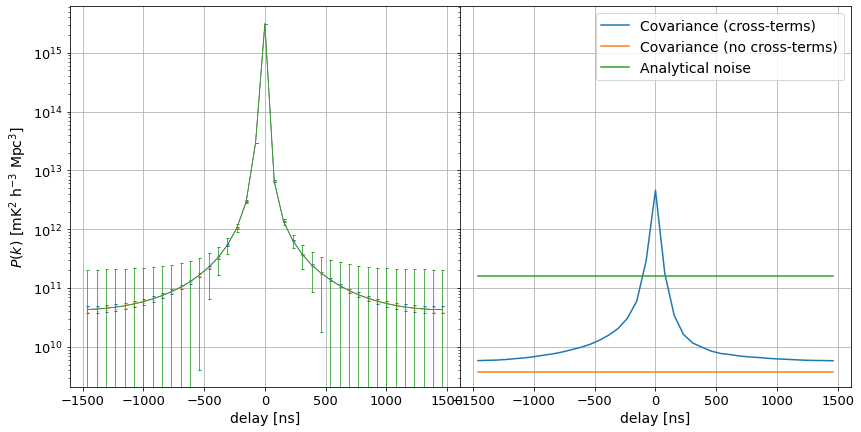

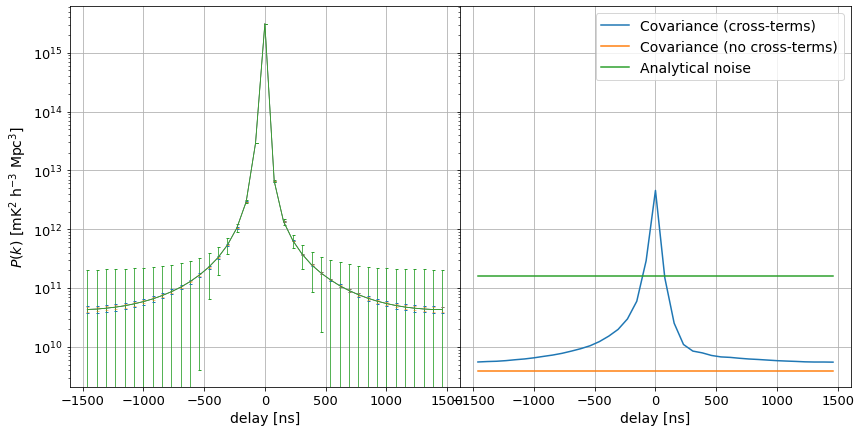

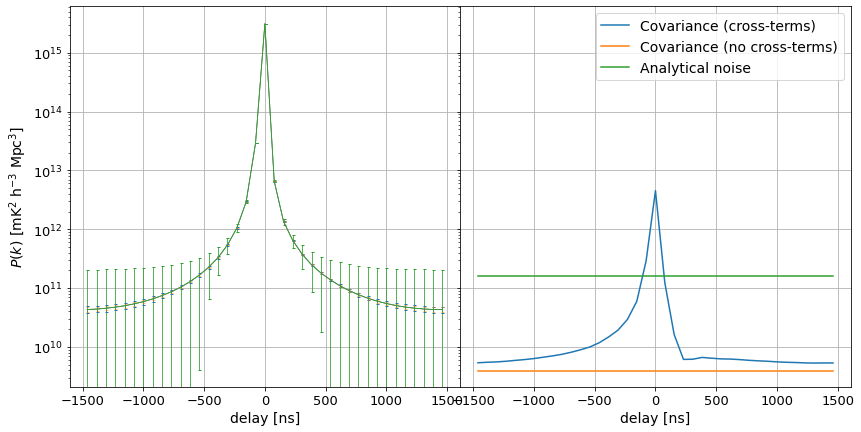

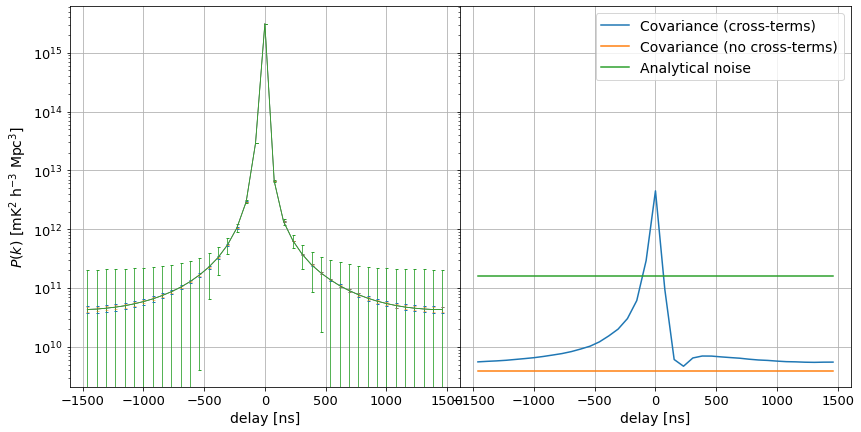

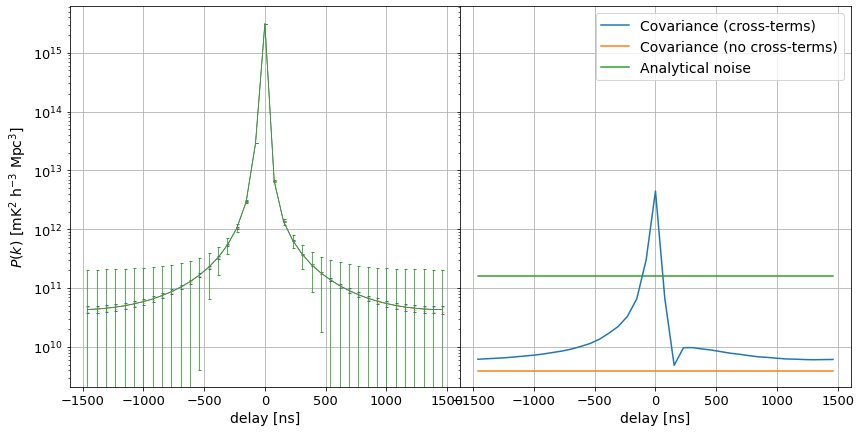

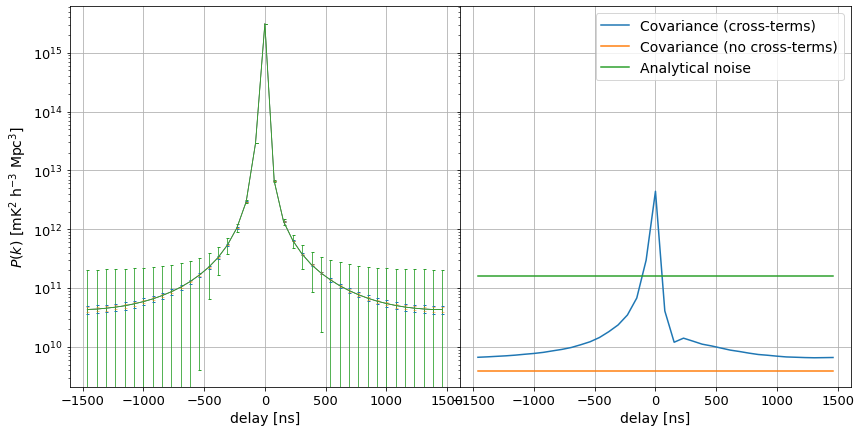

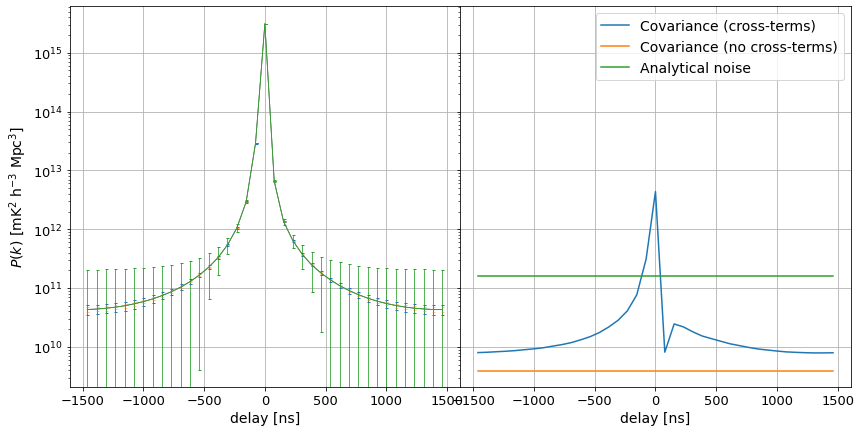

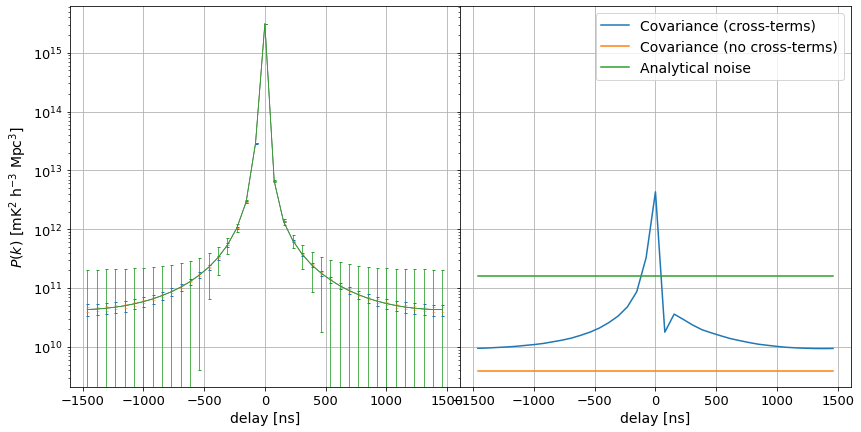

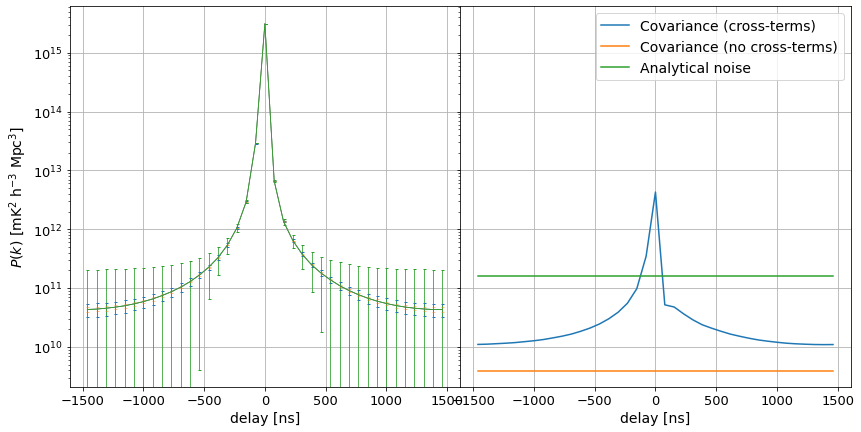

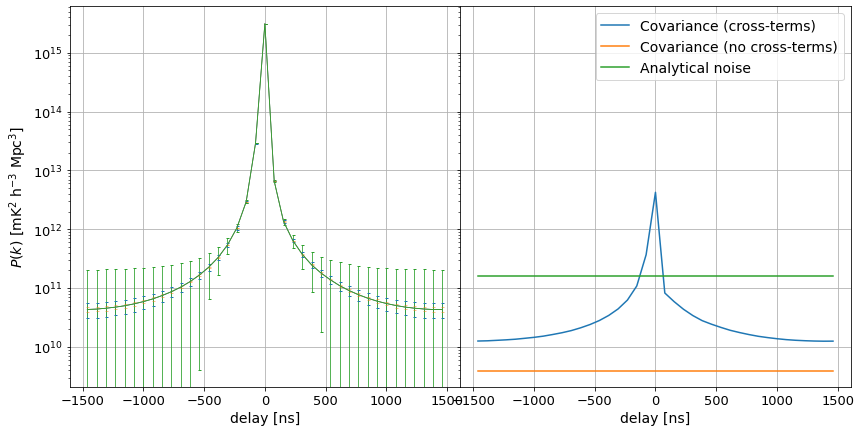

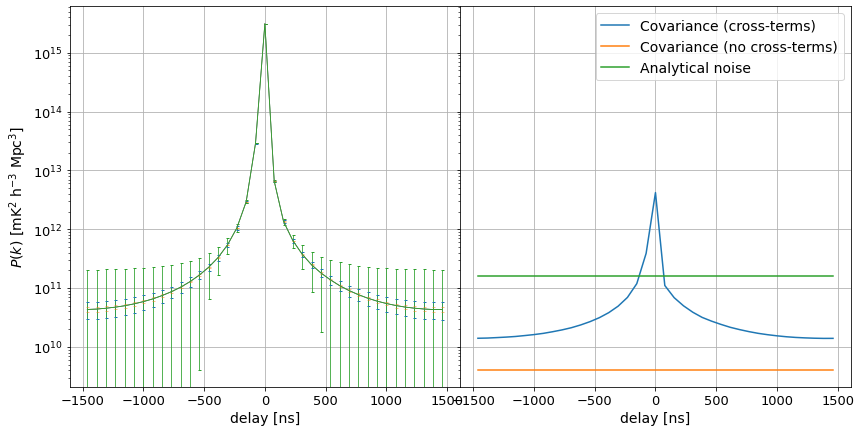

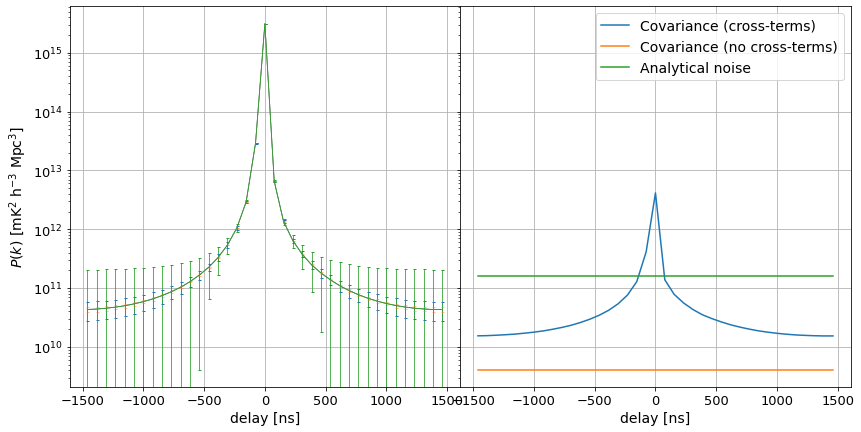

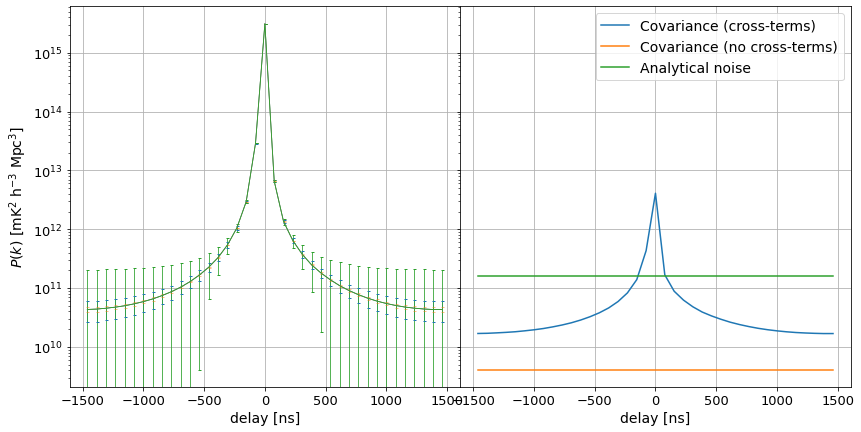

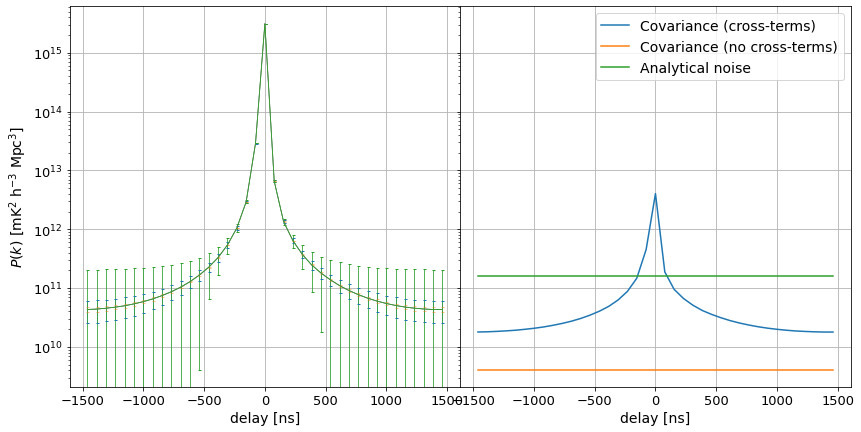

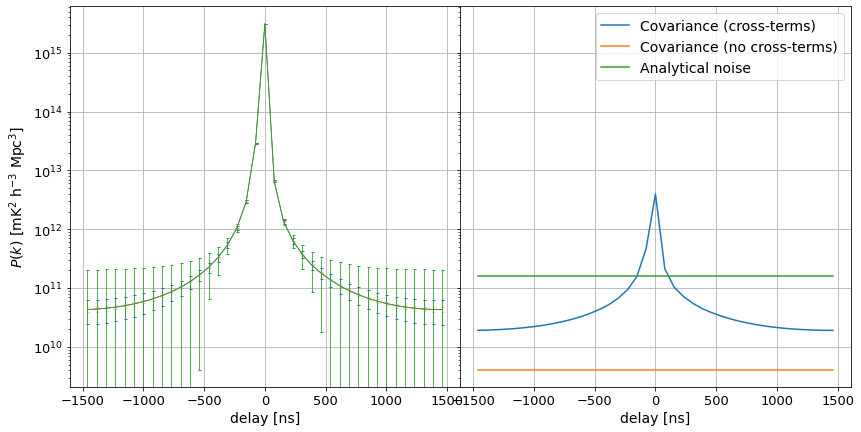

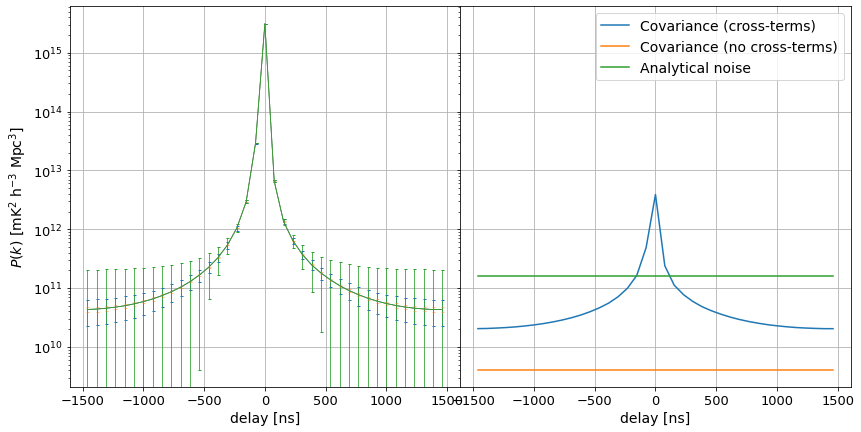

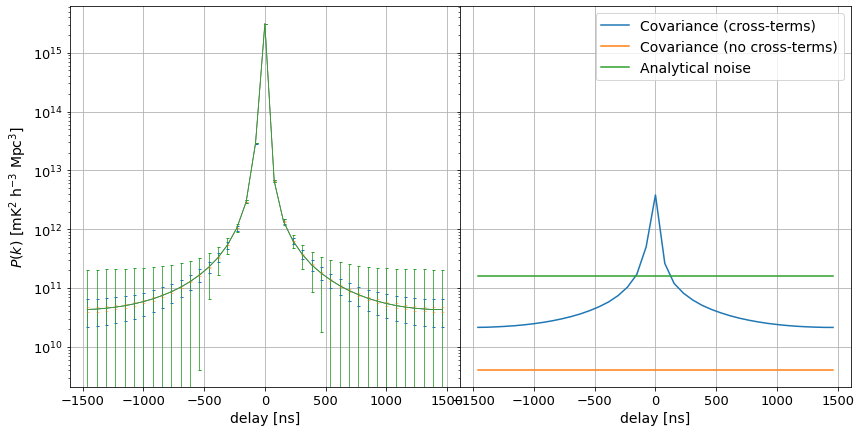

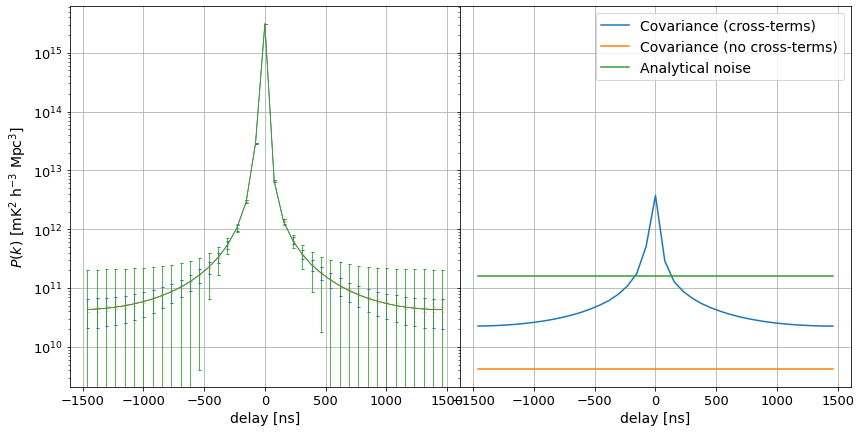

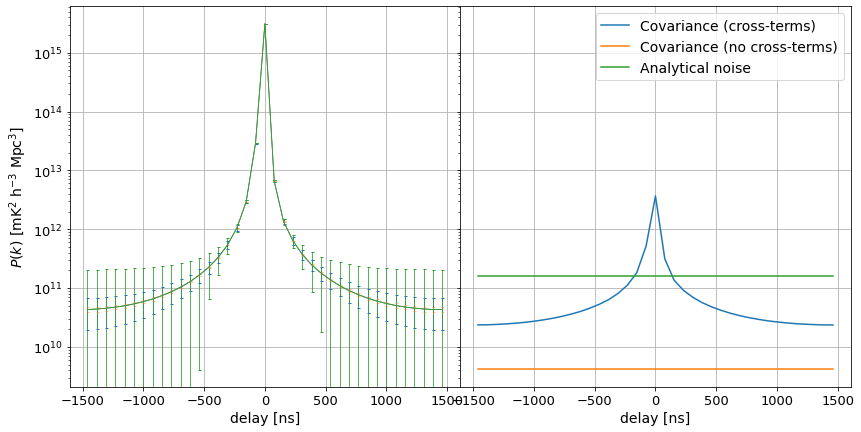

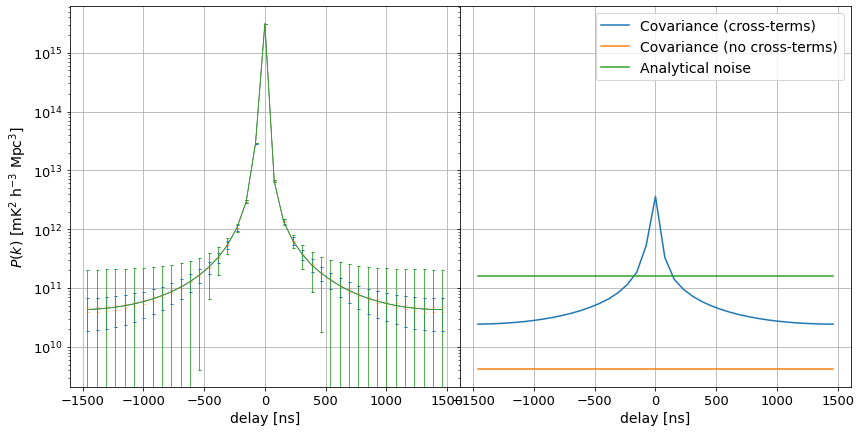

In [70]:
for time_index in range(uvp.Ntimes):
    C_nn = uvp_nn.get_cov(key,component='real')[time_index,:,:] #time-average
    err_nn = np.sqrt(np.abs(np.diag(C_nn[:,:])))

    C_ns = uvp_ns.get_cov(key,component='real')[time_index,:,:] #time-average
    err_ns = np.sqrt(np.abs(np.diag(C_ns[:,:])))
    
    fig, axes = plt.subplots(1,2,figsize=(14,7),sharey=True,gridspec_kw={'wspace':0})
    axes[0].errorbar(dlys,ps,yerr=err_ns,label='Errors from covariance (cross-terms)',capsize=1.5,lw=.8)
    axes[0].errorbar(dlys,ps,yerr=err_nn,label='Errors from covariance (no cross-terms)',alpha=.5,capsize=1.5,lw=.8)
    axes[0].errorbar(dlys,ps,yerr=P_N[0,:],label='Errors from thermal noise',capsize=1.5,lw=.8)

    axes[1].plot(dlys,err_ns,label='Covariance (cross-terms)')
    axes[1].plot(dlys,err_nn,label='Covariance (no cross-terms)')
    axes[1].plot(dlys,P_N[0,:],lw=1.5,label='Analytical noise')

    axes[1].legend(fontsize=14)
    for i in range(len(axes)):
        axes[i].set_xlabel("delay [ns]", fontsize=14)
        axes[i].tick_params(labelsize=13)
        axes[i].set_yscale('log')
        axes[i].grid()
    axes[0].set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)


## Flags that are not separable

**2.3** Repeat the analysis from 1.1, but with flags that are not separable in frequency and time, and which differ between baselines.


Not done. Too close to code extension

# Window functions and covariance

**3.1** Produce plots of the window functions of the 1D (spherically-averaged) delay spectrum bandpowers, assuming identity weighting.

Compute power spectrum

In [71]:
# calculate all baseline pairs from redundant group
baselines = blp_group[1] 
print(baselines)
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines, 
                                     exclude_auto_bls=True,exclude_permutations=False)

[(0, 1), (1, 2), (3, 4), (4, 5), (5, 6), (7, 8), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (18, 19), (19, 20), (20, 21), (21, 22), (23, 24), (24, 25), (25, 26), (27, 28), (28, 29)]


In [72]:
uvp = ds.pspec(baselines1, baselines2, dsets=(0,1), pols=[(pol,pol)], spw_ranges=[spw_range], norm='I', verbose=False,
               cov_model='empirical', store_cov=True)

Producing time-uniform covariance matrices between bandpowers.
Casting complex values to real discards the imaginary part


In [73]:
blp = blpairs[0]
key1=(0,blp[0])
key2=(1,blp[0])
G=ds.get_G(key1,key2,exact_norm=True,pol=pol)
H=ds.get_H(key1,key2,exact_norm=True,pol=pol)

Get normalisation matrix and window functions:

In [74]:
M,W=ds.get_MW(G,H,mode='I')

(39, 39)

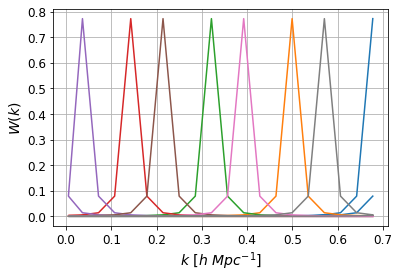

In [75]:
k_perp, k_para = uvp.get_kperps(spw, little_h=True), uvp.get_kparas(spw, little_h=True) 
k_arr = np.sqrt(np.mean(k_perp)**2+k_para**2)
fig,ax=plt.subplots(1,1)
for i in np.arange(0,W.shape[-1],5):
    ax.plot(k_arr,np.real(W[i,:]))
ax.grid()
ax.set_xlabel(r"$k\ [h\ Mpc^{-1}]$", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylabel(r"$W(k)$", fontsize=14)
W.shape

**3.2** Repeat the analysis from 1.1, but with a user-defined covariance matrix of the form C(𝜈, 𝜈’) ~ exp(-[(𝜈 - 𝜈’)/(10 MHz)]2), common to all baselines.

Not done. Too close to code extension

**3.3** Repeat with a per-baseline covariance.

Not done. Too close to code extension